In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Standard library imports
import json
import logging
import os
import random
import sys
import time

from collections import defaultdict
from multiprocessing import Pool, cpu_count
from typing import Dict, List, Optional, Tuple, Union
import warnings

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Graphs and networks
import networkx as nx
import igraph as ig
import scipy.sparse as sparse

# Scientific computing
import math
from scipy.interpolate import CubicSpline, interp1d
from scipy.spatial import cKDTree

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_hex, to_rgb
from mpl_toolkits.mplot3d import Axes3D

# Data visualization and processing
import colorcet as cc
import datashader as ds
import datashader.transfer_functions as tf

# from datashader.bundling import hammer_bundle

# Performance optimization
from numba import jit, prange

# Progress bars
from tqdm.notebook import tqdm

# Custom modules
from bundling3D import *
from fa2_modified import ForceAtlas2

# Set Seaborn style for plots
sns.set_style("white")

In [3]:
# 2. Constants and configuration
INPUT_GRAPH_PATH = "../data/07-clustered-graphs/alpha0.3_k10_res0.002.graphml"
CLUSTER_INFO_LABEL_TREE = "../output/cluster-qualifications/ClusterInfoLabelTree.xlsx"
CLUSTER_LABEL_DICT_PATH = "../data/99-testdata/cluster_label_dict.json"
CLUSTER_TREE_PATH = "../output/cluster-qualifications/ClusterHierachy_noComments.json"
OUTPUT_DIR = "../data/99-testdata/"
THREEJS_OUTPUT_DIR = (
    "/Users/jlq293/Projects/Random Projects/LW-ThreeJS/2d_ssrinetworkviz/src/data/"
)
CLUSTER_HIERACHY_FOR_LEGEND_PATH = (
    "../output/cluster-qualifications/ClusterHierachy_noComments.json"
)

FR_GRAPH_FILENAME = "fr_0to100clusters.graphml"

NODES_DATA_FILENAME = "NodesData0to100_BundlPerc50_BW0,4.json"
EDGES_DATA_FILENAME = "EdgesData0to100_BundlPerc50_BW0,4.json"

# Classes


## Utility functions


In [4]:
class GraphDataFrameUtility:
    """
    A utility class for converting igraph graph attributes to pandas DataFrames
    and performing DataFrame operations related to graph data.
    """

    @staticmethod
    def minmax_normalize(
        data: Union[List[float], np.ndarray], new_range: Tuple[float, float] = (0, 1)
    ) -> np.ndarray:
        data = np.array(data)
        if len(data) == 0:
            raise ValueError("Input data is empty")

        data_min, data_max = np.min(data), np.max(data)
        if data_min == data_max:
            raise ValueError("All values in the input data are identical")

        normalized_data = (data - data_min) / (data_max - data_min)

        if new_range != (0, 1):
            new_min, new_max = new_range
            normalized_data = normalized_data * (new_max - new_min) + new_min

        return normalized_data

    def minmax_denormalize(
        normalized_data: Union[List[float], np.ndarray],
        original_range: Tuple[float, float],
        current_range: Tuple[float, float] = (0, 1),
    ) -> np.ndarray:

        normalized_data = np.array(normalized_data)
        if len(normalized_data) == 0:
            raise ValueError("Input data is empty")

        orig_min, orig_max = original_range
        curr_min, curr_max = current_range

        if orig_min >= orig_max or curr_min >= curr_max:
            raise ValueError("Invalid range: min should be less than max")

        # First, normalize to [0, 1] if not already
        if current_range != (0, 1):
            normalized_data = (normalized_data - curr_min) / (curr_max - curr_min)

        # Then, scale to original range
        denormalized_data = normalized_data * (orig_max - orig_min) + orig_min

        return denormalized_data

    @staticmethod
    def edges_to_dataframe(g: ig.Graph) -> pd.DataFrame:
        """
        Convert the edges and their attributes of an igraph graph to a pandas DataFrame.

        Args:
            g (ig.Graph): The input igraph graph.

        Returns:
            pd.DataFrame: A DataFrame containing edge attributes, source, and target nodes.
        """
        # check if networkx or igraph
        if isinstance(g, nx.Graph):
            g = ig.Graph.from_networkx(g)
        # Extract edge attributes
        edge_data = {attr: g.es[attr] for attr in g.es.attributes()}

        # Add source and target node indices
        edge_data["source"] = [e.source for e in g.es]
        edge_data["target"] = [e.target for e in g.es]

        # Convert to DataFrame
        edge_dataframe = pd.DataFrame(edge_data)

        return edge_dataframe

    @staticmethod
    def nodes_to_dataframe(
        g: ig.Graph,
        normalize_coordinates: bool = False,
        drop_columns: Optional[List[str]] = None,
    ) -> pd.DataFrame:
        """
        Convert the nodes and their attributes of an igraph graph to a pandas DataFrame.

        Args:
            g (ig.Graph): The input igraph graph.
            drop_columns (Optional[List[str]]): A list of column names to drop from the DataFrame.

        Returns:
            pd.DataFrame: A DataFrame containing node attributes and node indices.
        """
        # check if networkx or igraph
        if isinstance(g, nx.Graph):
            g = ig.Graph.from_networkx(g)
        # Extract node attributes
        node_data = {attr: g.vs[attr] for attr in g.vs.attributes()}

        # Add node indices
        node_dataframe = pd.DataFrame(node_data)
        node_dataframe["node_index"] = [n.index for n in g.vs]
        if normalize_coordinates:
            # Calculate min/max for coordinates
            xmin, xmax = np.min(node_dataframe["x"]), np.max(node_dataframe["x"])
            ymin, ymax = np.min(node_dataframe["y"]), np.max(node_dataframe["y"])
            zmin, zmax = np.min(node_dataframe["z"]), np.max(node_dataframe["z"])

            # Normalize coordinates
            node_dataframe["x"] = minmax_normalize(node_dataframe["x"], xmin, xmax)
            node_dataframe["y"] = minmax_normalize(node_dataframe["y"], ymin, ymax)
            node_dataframe["z"] = minmax_normalize(node_dataframe["z"], zmin, zmax)
            print("Coordinates normalized to [0, 1] range.")

        # Drop specified columns if provided
        if drop_columns:
            node_dataframe = node_dataframe.drop(columns=drop_columns, errors="ignore")

        return node_dataframe

    @staticmethod
    def create_edge_df_with_source_target_coords(g: ig.Graph) -> pd.DataFrame:
        """
        Create a DataFrame containing edge information with source and target coordinates.

        This method processes an igraph Graph object and extracts edge information,
        including weights, IDs, source and target nodes, and their coordinates.
        It also calculates the length of each edge segment.

        Parameters:
        -----------
        g : ig.Graph
            The input graph object from which to extract edge information.

        Returns:
        --------
        pd.DataFrame
            A DataFrame containing the following columns:
            - weight: Edge weight
            - edge_id: Unique identifier for each edge
            - source: Source node ID
            - target: Target node ID
            - source_x, source_y, source_z: Coordinates of the source node
            - target_x, target_y, target_z: Coordinates of the target node
            - segment_length: Euclidean distance between source and target nodes

        Notes:
        ------
        - Assumes the graph nodes have 'x', 'y', and 'z' attributes for coordinates.
        - Prints statistics about segment lengths after creating the DataFrame.
        """
        edge_data = []
        for edge in g.es:
            source = edge.source
            target = edge.target
            source_coords = (g.vs[source]["x"], g.vs[source]["y"], g.vs[source]["z"])
            target_coords = (g.vs[target]["x"], g.vs[target]["y"], g.vs[target]["z"])

            edge_data.append(
                {
                    "weight": edge["weight"],
                    "edge_id": edge["edge_id"],
                    "source": source,
                    "target": target,
                    "source_x": source_coords[0],
                    "source_y": source_coords[1],
                    "source_z": source_coords[2],
                    "target_x": target_coords[0],
                    "target_y": target_coords[1],
                    "target_z": target_coords[2],
                    "segment_length": GraphDataFrameUtility.distance_between(
                        source_coords, target_coords
                    ),
                }
            )

        df = pd.DataFrame(edge_data)

        # Print segment length statistics
        print("Segment length statistics:")
        print(f"Min: {df['segment_length'].min():.2f}")
        print(f"Max: {df['segment_length'].max():.2f}")
        print(f"Mean: {df['segment_length'].mean():.2f}")
        print(f"Median: {df['segment_length'].median():.2f}")

        return df

    @staticmethod
    def distance_between(
        point1: Tuple[float, float, float], point2: Tuple[float, float, float]
    ) -> float:
        """Calculate the Euclidean distance between two 3D points."""
        return np.sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)))

## Graph reader


In [5]:
class GraphReader:
    @staticmethod
    def read_and_clean_graph(path: str) -> ig.Graph:
        g = ig.Graph.Read_GraphML(path)
        g.vs["node_id"] = [int(i) for i in range(g.vcount())]

        if "id" in g.vs.attribute_names():
            g.vs["node_name"] = g.vs["id"]
            del g.vs["id"]

        if "cluster" in g.vs.attribute_names():
            g.vs["cluster"] = [int(cluster) for cluster in g.vs["cluster"]]

        if "year" in g.vs.attribute_names():
            g.vs["year"] = [int(year) for year in g.vs["year"]]

        if "eid" in g.vs.attribute_names():
            del g.vs["eid"]

        if "centrality_alpha0.3_k10_res0.006" in g.vs.attribute_names():
            del g.vs["centrality_alpha0.3_k10_res0.006"]

        if "centrality_alpha0.3_k10_res0.002" in g.vs.attribute_names():
            g.vs["centrality"] = g.vs["centrality_alpha0.3_k10_res0.002"]
            del g.vs["centrality_alpha0.3_k10_res0.002"]

        g.es["edge_id"] = list(range(g.ecount()))
        print("Node Attributes:", g.vs.attribute_names())
        print("Edge Attributes:", g.es.attribute_names())
        # print number of nodes and edges
        print(f"Number of nodes: {g.vcount()}")
        print(f"Number of edges: {g.ecount()}")
        return g

    @staticmethod
    def subgraph_of_clusters(G, clusters):
        if isinstance(G, nx.Graph):
            nodes = [
                node for node in G.nodes if G.nodes[node].get("cluster") in clusters
            ]
            return G.subgraph(nodes)
        elif isinstance(G, ig.Graph):
            nodes = [v.index for v in G.vs if v["cluster"] in clusters]
            return G.subgraph(nodes)
        else:
            raise TypeError("Input must be a NetworkX Graph or an igraph Graph")

    @staticmethod
    def add_cluster_labels(
        G: Union[nx.Graph, ig.Graph],
        labels_file_path: str = "../output/cluster-qualifications/raw_cluster_labels.json",
    ) -> Tuple[Union[nx.Graph, ig.Graph], Dict[float, str]]:
        """
        Add cluster labels to the graph nodes.

        Args:
            G (Union[nx.Graph, ig.Graph]): The input graph (NetworkX or igraph).
            labels_file_path (str): Path to the JSON file containing cluster labels.

        Returns:
            Tuple[Union[nx.Graph, ig.Graph], Dict[float, str]]:
                The graph with added cluster labels and the cluster label dictionary.
        """
        with open(labels_file_path) as file:
            cluster_label_dict = json.load(file)
        cluster_label_dict = {float(k): v[0] for k, v in cluster_label_dict.items()}

        if isinstance(G, nx.Graph):
            for node in G.nodes:
                cluster = G.nodes[node]["cluster"]
                G.nodes[node]["cluster_label"] = cluster_label_dict.get(
                    cluster, "Unknown"
                )
        elif isinstance(G, ig.Graph):
            G.vs["cluster_label"] = [
                cluster_label_dict.get(v["cluster"], "Unknown") for v in G.vs
            ]
        else:
            raise TypeError("Input must be a NetworkX Graph or an igraph Graph")

        return G, cluster_label_dict

## Layout Utilities (Fruchterman-Reingold)


In [6]:
class LayoutUtility:
    """
    Layout utility class for igraph layout operations. made for fruchterman-reingold layout.

    Args:
        g (Union[nx.Graph, ig.Graph]): The input graph (NetworkX or igraph).
        layout_params (Optional[Dict]): The layout parameters.

    Returns:
        Tuple[nx.Graph, Dict]: The graph with assigned coordinates and the layout dictionary.
    """

    @staticmethod
    def fr_layout_nx(
        g: Union[nx.Graph, ig.Graph], layout_params: Optional[Dict] = None
    ) -> Tuple[nx.Graph, Dict]:
        print("Starting Fruchterman-Reingold layout process...")
        start_time = time.time()

        if layout_params is None:
            layout_params = {
                "iterations": 100,
                "threshold": 0.00001,
                "weight": "weight",
                "scale": 1,
                "center": (0, 0),
                "dim": 2,
                "seed": 1887,
            }
        print(f"Layout parameters: {layout_params}")

        if not isinstance(g, nx.Graph):
            print("Converting to NetworkX Graph...")
            G = g.to_networkx()
            print("Conversion complete.")
        else:
            G = g

        print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

        print("Calculating layout...")
        layout_start_time = time.time()
        pos = nx.spring_layout(G, **layout_params)
        layout_end_time = time.time()
        print(
            f"Layout calculation completed in {layout_end_time - layout_start_time:.2f} seconds."
        )

        print("Processing layout results...")
        node_xy_dict = {node: pos[node] for node in G.nodes}

        x_values, y_values = zip(*node_xy_dict.values())
        min_x, max_x = min(x_values), max(x_values)
        min_y, max_y = min(y_values), max(y_values)

        print(f"Layout boundaries:")
        print(f"X-axis: Min = {min_x:.2f}, Max = {max_x:.2f}")
        print(f"Y-axis: Min = {min_y:.2f}, Max = {max_y:.2f}")

        print("Assigning coordinates to nodes...")
        for node in G.nodes:
            G.nodes[node]["x"] = node_xy_dict[node][0]
            G.nodes[node]["y"] = node_xy_dict[node][1]

        end_time = time.time()
        total_time = end_time - start_time
        print(f"Layout process completed in {total_time:.2f} seconds.")

        return G, pos

### Add z coordinates to the nodes


In [7]:
class ZCoordinateAdder:
    """
    A class for adding a z-coordinate to the nodes of a graph based on their centrality values.
    The z-coordinate range is determined by a percentage of the x-y dimension range.
    """

    def __init__(self, g, percentage=50):
        self.g = g
        self.percentage = percentage / 100  # Convert percentage to decimal

    def add_z_coordinate_to_nodes(self):
        """
        Add a z-coordinate to the nodes of the graph based on their centrality values.
        Args:
            g (nx.Graph): The input graph.
            percentage (float): The percentage of x-y dimension range to use for z-coordinate range.
        Returns:
            nx.Graph: The graph with the z-coordinate added to the nodes.
        """
        # Calculate the bounds of x and y coordinates
        xvalues = [attributes["x"] for _, attributes in self.g.nodes(data=True)]
        yvalues = [attributes["y"] for _, attributes in self.g.nodes(data=True)]
        min_x, max_x = min(xvalues), max(xvalues)
        min_y, max_y = min(yvalues), max(yvalues)

        # Calculate the range of x and y
        x_range = max_x - min_x
        y_range = max_y - min_y

        # Calculate the maximum z range based on the larger of x or y range
        max_z_range = max(x_range, y_range) * self.percentage

        print("Bounds of the layout:")
        print(f"Min x: {min_x}, Max x: {max_x}")
        print(f"Min y: {min_y}, Max y: {max_y}")
        print(f"Z coordinate range: 0 to {max_z_range}")

        # Extract centrality values from nodes
        centralities = np.array(
            [self.g.nodes[node]["centrality"] for node in self.g.nodes]
        )

        # Normalize centrality values to range [0, 1]
        centrality_min = centralities.min()
        centrality_max = centralities.max()
        centralities_normalized = (centralities - centrality_min) / (
            centrality_max - centrality_min
        )

        # Scale the normalized centralities to the desired z range
        z_coordinates = centralities_normalized * max_z_range

        # Add z-coordinate to nodes
        for i, node in enumerate(self.g.nodes):
            self.g.nodes[node]["z"] = z_coordinates[i]

        # Describe the distribution of z values
        print("Description of the Z coordinate values:")
        print(pd.Series(z_coordinates).describe())
        print("Z coordinate added to nodes")

        return self.g

# Prune edges


In [8]:
import igraph as ig
import numpy as np
import random
from typing import Dict


class PruneEdges:
    """
    A class for pruning edges in a graph based on specific criteria, such as edge weight percentiles or random selection.
    """

    def __init__(self):
        self.initial_edge_count = 0
        self.initial_isolates = 0
        self.final_edge_count = 0
        self.final_isolates = 0

    def _update_statistics(self, g: ig.Graph, g_modified: ig.Graph) -> None:
        """
        Update class attributes related to graph statistics.

        Args:
            g (ig.Graph): The original graph.
            g_modified (ig.Graph): The modified graph after pruning or random selection.
        """
        # if nx object, convert to igraph
        if isinstance(g, nx.Graph):
            g = ig.Graph.from_networkx(g)
        self.initial_edge_count = g.ecount()
        self.initial_isolates = len(g.vs.select(_degree=0))
        self.final_edge_count = g_modified.ecount()
        self.final_isolates = len(g_modified.vs.select(_degree=0))

    def prune_edges_by_percentile_weight(
        self, g: ig.Graph, percentile: float
    ) -> ig.Graph:
        """
        Remove edges from the graph that have weight less than or equal to the specified percentile weight.

        Args:
            g (ig.Graph): The input graph. Must have a 'weight' attribute for edges.
            percentile (float): The percentile to use as the threshold for pruning edges.

        Returns:
            ig.Graph: A new graph with edges removed based on the specified percentile.

        Raises:
            ValueError: If the input graph has no 'weight' attribute for edges.
            ValueError: If percentile is not between 0 and 100.
        """
        # if nx object, convert to igraph
        if isinstance(g, nx.Graph):
            g = ig.Graph.from_networkx(g)
        if not (0 <= percentile <= 100):
            raise ValueError("Percentile must be between 0 and 100.")

        if "weight" not in g.es.attributes():
            raise ValueError("Input graph must have a 'weight' attribute for edges.")

        # Get all weights and calculate the specified percentile
        weights = g.es["weight"]
        weight_threshold = np.percentile(weights, percentile)

        # Identify edges to keep
        edges_to_keep = [
            edge.index for edge in g.es if edge["weight"] > weight_threshold
        ]
        threshold_edges = [
            edge.index for edge in g.es if edge["weight"] == weight_threshold
        ]

        # Randomly select from threshold edges to reach target number of edges
        target_edge_count = int(self.initial_edge_count * (1 - percentile / 100))
        edges_to_add = target_edge_count - len(edges_to_keep)
        if edges_to_add > 0:
            random.shuffle(threshold_edges)
            edges_to_keep.extend(threshold_edges[:edges_to_add])

        # Create a new graph with only the selected edges
        g_pruned = g.subgraph_edges(edges_to_keep, delete_vertices=False)

        # Update statistics
        self._update_statistics(g, g_pruned)

        return g_pruned

    def keep_random_percentile_of_edges(
        self, g: ig.Graph, percentile: float
    ) -> ig.Graph:
        """
        Keep a random selection of edges based on the provided percentile.

        Args:
            g (ig.Graph): The input graph.
            percentile (float): The percentile of edges to keep (0-100).

        Returns:
            ig.Graph: A new graph with the randomly selected edges.

        Raises:
            ValueError: If percentile is not between 0 and 100.
        """
        # if nx object, convert to igraph
        if isinstance(g, nx.Graph):
            g = ig.Graph.from_networkx(g)
        if not (0 <= percentile <= 100):
            raise ValueError("percentile must be between 0 and 100.")

        # Calculate the number of edges to keep
        total_edges = g.ecount()
        num_edges_to_keep = int(total_edges * (percentile / 100))

        # Randomly select edges to keep
        all_edges = list(range(total_edges))
        random.shuffle(all_edges)
        edges_to_keep = all_edges[:num_edges_to_keep]

        # Create a new graph with only the selected edges
        g_random = g.subgraph_edges(edges_to_keep, delete_vertices=False)

        # Update statistics
        self._update_statistics(g, g_random)

        return g_random

    def get_prune_summary(self) -> Dict[str, int]:
        """
        Returns a summary of the pruning process.

        Returns:
            Dict[str, int]: A dictionary containing the initial and final edge counts and the number of isolates.
        """
        return {
            "initial_edge_count": self.initial_edge_count,
            "final_edge_count": self.final_edge_count,
            "initial_isolates": self.initial_isolates,
            "final_isolates": self.final_isolates,
        }


# example usage
# g = ... # your graph object
# pruner = PruneEdges()
# g_pruned = pruner.prune_edges_by_percentile_weight(g, 10)
# summary = pruner.get_prune_summary()

## Nodes Saver


# Start the algorithm


## read and layout the graph


In [12]:
# g = GraphReader.read_and_clean_graph(INPUT_GRAPH_PATH)
g = GraphReader.read_and_clean_graph(
    "/Users/jlq293/Projects/Study-1-Bibliometrics/data/07-clustered-graphs/alpha0.3_k10_res0.002.graphml"
)
cluster_list = list(range(0, 101))

# subset to only cluster 0 to 100
g = GraphReader.subgraph_of_clusters(g, cluster_list)

total_nodes = len(g.vs)
################################################################################################
layout_params = {
    # "k": 0.5, # distance between nodes; best to leave it to algo
    "iterations": 50,  # (default=50) use 100
    "threshold": 0.0001,  # default 0.0001
    "weight": "weight",
    "scale": 5000,
    "center": (0, 0),
    "dim": 2,
    "seed": 1887,
}

g_fr, pos = LayoutUtility.fr_layout_nx(g, layout_params)


print("#" * 100)
print("Layout done")
print("#" * 100)

################################################################################################

# Add z-coordinate to nodes based on centrality
z_adder = ZCoordinateAdder(g_fr, percentage=20)
g_z = z_adder.add_z_coordinate_to_nodes()

print("#" * 100)
print("Z coordinate added to nodes")
print("#" * 100)

/var/folders/6m/zjbwrdgj0bg9zyhx3l7134mm0000gn/T/ipykernel_39661/1447177093.py:4: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:488
  g = ig.Graph.Read_GraphML(path)


Node Attributes: ['doi', 'year', 'title', 'cluster', 'node_id', 'node_name', 'centrality']
Edge Attributes: ['weight', 'edge_id']
Number of nodes: 40643
Number of edges: 602779
Starting Fruchterman-Reingold layout process...
Layout parameters: {'iterations': 50, 'threshold': 0.0001, 'weight': 'weight', 'scale': 5000, 'center': (0, 0), 'dim': 2, 'seed': 1887}
Converting to NetworkX Graph...
Conversion complete.
Graph has 37804 nodes and 564246 edges.
Calculating layout...
Layout calculation completed in 1931.34 seconds.
Processing layout results...
Layout boundaries:
X-axis: Min = -5000.00, Max = 3732.82
Y-axis: Min = -3769.51, Max = 3854.39
Assigning coordinates to nodes...
Layout process completed in 1933.11 seconds.
####################################################################################################
Layout done
####################################################################################################
Bounds of the layout:
Min x: -5000.0, Max x: 3732.81616210

In [9]:
# Assuming g_z is your NetworkX graph object

path = "/Users/jlq293/Projects/Study-1-Bibliometrics/data/99-testdata/"
full_path = path + FR_GRAPH_FILENAME

# Save as GraphML file
# nx.write_graphml(g_z, full_path)

print(f"Graph saved as GraphML: {full_path}")


# read back in
g_z = nx.read_graphml(full_path)

Graph saved as GraphML: /Users/jlq293/Projects/Study-1-Bibliometrics/data/99-testdata/fr_0to100clusters.graphml


## Prune


In [10]:
################################################################################################
# prune edges
pruning_weight_percentile = 25
pruner = PruneEdges()
g_pruned_weight = pruner.prune_edges_by_percentile_weight(
    g_z, pruning_weight_percentile
)
summary = pruner.get_prune_summary()
print(summary)

# random percentage of edges
pruning_random_percentile = 25
pruner = PruneEdges()
g_pruned_random = pruner.keep_random_percentile_of_edges(g_z, pruning_random_percentile)
summary = pruner.get_prune_summary()
print(summary)
print("#" * 100)

{'initial_edge_count': 564246, 'final_edge_count': 267167, 'initial_isolates': 0, 'final_isolates': 0}
{'initial_edge_count': 564246, 'final_edge_count': 141061, 'initial_isolates': 0, 'final_isolates': 425}
####################################################################################################


## Dataframe conversion


In [11]:
# Assume `g` is an igraph.Graph object and you have the utility class imported.
edges_df = GraphDataFrameUtility.edges_to_dataframe(g_pruned_random)
# Create edge and node DataFrames
nodes_df = GraphDataFrameUtility.nodes_to_dataframe(
    g_pruned_random, normalize_coordinates=False, drop_columns=["node_id", "node_name"]
)

# Merge edge and node positions
edge_df_with_source_target_coords = (
    GraphDataFrameUtility.create_edge_df_with_source_target_coords(g_pruned_random)
)

Segment length statistics:
Min: 0.00
Max: 4021.77
Mean: 844.71
Median: 752.23


In [13]:
# get dictionary of segment length, 25th, 50th, 75th percentile
segment_length_dict = {
    "10th_percentile": edge_df_with_source_target_coords["segment_length"].quantile(
        0.10
    ),
    "25th_percentile": edge_df_with_source_target_coords["segment_length"].quantile(
        0.25
    ),
    "50th_percentile": edge_df_with_source_target_coords["segment_length"].median(),
    "75th_percentile": edge_df_with_source_target_coords["segment_length"].quantile(
        0.75
    ),
}
segment_length_dict

{'10th_percentile': 304.129170530789,
 '25th_percentile': 480.03024806059074,
 '50th_percentile': 752.2250815491802,
 '75th_percentile': 1111.2734952635042}

## quick check


(37804, 37804)


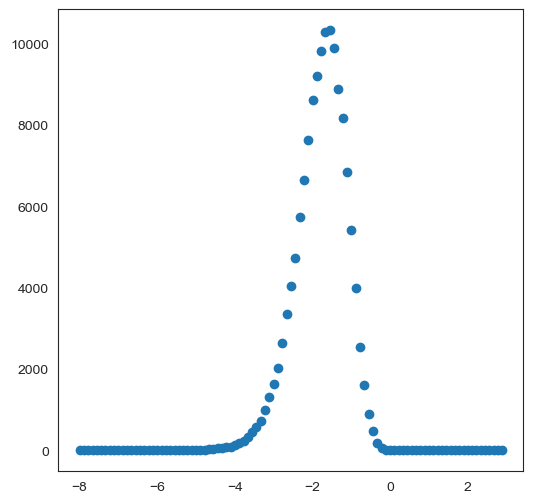

In [18]:
normalized_edge_df_with_source_target_coords = edge_df_with_source_target_coords.copy()
to_normalize = [
    "source_x",
    "source_y",
    "source_z",
    "target_x",
    "target_y",
    "target_z",
    "segment_length",
]
for col in to_normalize:
    normalized_edge_df_with_source_target_coords[col] = (
        GraphDataFrameUtility.minmax_normalize(
            normalized_edge_df_with_source_target_coords[col]
        )
    )

Nnodes = nodes_df.shape[0]

subedges = (
    normalized_edge_df_with_source_target_coords["segment_length"]
    > normalized_edge_df_with_source_target_coords["segment_length"].median()
)

mat = sparse.coo_matrix(
    (
        np.ones(
            normalized_edge_df_with_source_target_coords.loc[subedges].shape[0],
            dtype=int,
        ),
        (
            normalized_edge_df_with_source_target_coords.loc[subedges, "source"].values,
            normalized_edge_df_with_source_target_coords.loc[subedges, "target"].values,
        ),
    ),
    shape=(Nnodes, Nnodes),
)

print(mat.shape)

ncomp, membership = sparse.csgraph.connected_components(mat)

mvalue, mcounts = np.unique(membership, return_counts=True)
mcounts, mcountdist = np.unique(mcounts, return_counts=True)

# mcounts, mcountdist

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

dist, bins = np.histogram(
    normalized_edge_df_with_source_target_coords["segment_length"].values,
    bins=np.exp(np.linspace(-8, 3, 100)),
)

ax.scatter(np.log(bins[:-1]), dist)

plt.show()

# BUNDLE


## Set Threshold for Edge Length


In [15]:
# get edges to bundle above a certain threshold
# threshold = 0.03
threshold = segment_length_dict["50th_percentile"]
edges_to_bundle = edge_df_with_source_target_coords["segment_length"] > threshold
edges_to_bundle_df = edge_df_with_source_target_coords.loc[edges_to_bundle].reset_index(
    drop=True
)
print(f"Total Nr of Pruned Edges: {len(edge_df_with_source_target_coords)}")
print(f"Edges to Bundle: {edges_to_bundle.sum()}")

Total Nr of Pruned Edges: 141061
Edges to Bundle: 70530


## Bundling


In [20]:
normalized_edge_df_with_source_target_coords["segment_length"].median() / 2

0.09351909553512086

In [26]:
0.025 / 2.0

0.0125

In [27]:
bundled_edge_pts = hammer_bundle(
    nodes_df[["x", "y", "z"]],
    edges_to_bundle_df[["source", "target"]],
    initial_bandwidth=0.10,  # 0.01,
    decay=0.7,  # 0.8,
    tension=0.5,  # 0.8,
    accuracy=5 * 10**2,
    weight=None,
    advect_iterations=50,
    iterations=5,
    min_segment_length=0.01,
    max_segment_length=0.05,
)
bundled_edge_pts.head()

Process Bundling
Start Bundling


## Post Bundling Processing

add source and target columns, create clean df and save it


In [22]:
class EdgeProcessor:
    """
    A class to process edge data for graph visualization.

    This class handles the creation of bundled and straight edges from input dataframes,
    concatenates the results, and cleans the edge attributes for further analysis or visualization.

    Attributes:
    bundled_edge_pts (pd.DataFrame): DataFrame containing points for bundled edges.
    edges_to_bundle_df (pd.DataFrame): DataFrame mapping edges to their source and target nodes.
    edge_df_with_source_target_coords (pd.DataFrame): DataFrame containing all edge coordinates and their lengths.
    threshold (float): Length threshold to determine which edges are considered straight.
    """

    def __init__(
        self,
        bundled_edge_pts,
        edges_to_bundle_df,
        edge_df_with_source_target_coords,
        threshold,
    ):
        self.bundled_edge_pts = bundled_edge_pts
        self.edges_to_bundle_df = edges_to_bundle_df
        self.edge_df_with_source_target_coords = edge_df_with_source_target_coords
        self.threshold = threshold

    def create_bundled_edges_df(self):
        sub_bundle_idx = 0
        x, y, z = [], [], []
        bundled_edges_dict = {}

        for i in range(len(self.bundled_edge_pts)):
            # if not nan
            if pd.isna(self.bundled_edge_pts.iloc[i, 0]):
                target = self.edges_to_bundle_df.loc[sub_bundle_idx, "target"]
                source = self.edges_to_bundle_df.loc[sub_bundle_idx, "source"]
                bundled_edges_dict[(source, target)] = {
                    "x": x,
                    "y": y,
                    "z": z,
                }
                sub_bundle_idx += 1
                x, y, z = [], [], []
            else:
                x.append(self.bundled_edge_pts.iloc[i, 0])
                y.append(self.bundled_edge_pts.iloc[i, 1])
                z.append(self.bundled_edge_pts.iloc[i, 2])

        # Create DataFrame
        bundled_edges_df = pd.DataFrame.from_dict(bundled_edges_dict, orient="index")
        bundled_edges_df["source"] = [x[0] for x in bundled_edges_df.index]
        bundled_edges_df["target"] = [x[1] for x in bundled_edges_df.index]
        bundled_edges_df.reset_index(drop=True, inplace=True)
        print(f"Number of bundled edges: {bundled_edges_df.shape[0]}")
        return bundled_edges_df

    def create_straight_edges_df(self):
        straight_edges_mask = (
            self.edge_df_with_source_target_coords["segment_length"] <= self.threshold
        )

        straight_edges_df = self.edge_df_with_source_target_coords.loc[
            straight_edges_mask,
            [
                "source",
                "target",
                "source_x",
                "source_y",
                "source_z",
                "target_x",
                "target_y",
                "target_z",
            ],
        ].reset_index(drop=True)

        straight_edges_df["x"] = [
            [source_x, target_x]
            for source_x, target_x in zip(
                straight_edges_df["source_x"], straight_edges_df["target_x"]
            )
        ]
        straight_edges_df["y"] = [
            [source_y, target_y]
            for source_y, target_y in zip(
                straight_edges_df["source_y"], straight_edges_df["target_y"]
            )
        ]
        straight_edges_df["z"] = [
            [source_z, target_z]
            for source_z, target_z in zip(
                straight_edges_df["source_z"], straight_edges_df["target_z"]
            )
        ]

        # Drop coordinate columns
        straight_edges_df = straight_edges_df.drop(
            columns=[
                "source_x",
                "source_y",
                "source_z",
                "target_x",
                "target_y",
                "target_z",
            ]
        )

        return straight_edges_df

    def concat_and_clean_edges(self, bundled_edges_df, straight_edges_df):
        # Concatenate bundled and straight edges
        final_edges_df = pd.concat(
            [bundled_edges_df, straight_edges_df], ignore_index=True
        )

        # Round to 10 decimal places in x, y, z
        for coord in ["x", "y", "z"]:
            final_edges_df[coord] = final_edges_df[coord].apply(
                lambda points: [round(i, 10) for i in points]
            )

        return final_edges_df

    def post_process_edges(self):
        bundled_edges_df = self.create_bundled_edges_df()
        straight_edges_df = self.create_straight_edges_df()
        final_edges_df = self.concat_and_clean_edges(
            bundled_edges_df, straight_edges_df
        )

        print(f"Number of total edges: {final_edges_df.shape[0]}")
        print(f"Number of straight edges: {straight_edges_df.shape[0]}")

        return final_edges_df


# Example of how to use the class
edge_processor = EdgeProcessor(
    bundled_edge_pts, edges_to_bundle_df, edge_df_with_source_target_coords, threshold
)
final_edges_df = edge_processor.post_process_edges()

Number of bundled edges: 70530
Number of total edges: 141061
Number of straight edges: 70531


# SAVER


In [23]:
class EdgeTransformer:
    def __init__(self, edges_df, nodes_df):
        self.edges_df = edges_df
        self.nodes_df = nodes_df

    def add_color_attr(self):
        """
        Add cluster information to edges based on node clusters.
        If nodes are in the same cluster, the cluster ID is added; otherwise, -1 is added.
        """
        self.edges_df["color"] = [
            (
                self.nodes_df.loc[source, "cluster"]
                if self.nodes_df.loc[source, "cluster"]
                == self.nodes_df.loc[target, "cluster"]
                else -1
            )
            for source, target in zip(self.edges_df["source"], self.edges_df["target"])
        ]
        return self.edges_df

    def transform_edges(
        self, x_col="x", y_col="y", z_col="z", extra_edge_attributes=None
    ):
        """
        Transform edge data from a DataFrame into a list of dictionaries with points and extra attributes.

        Args:
        x_col (str): Name of the column containing x-coordinates. Default is "x".
        y_col (str): Name of the column containing y-coordinates. Default is "y".
        z_col (str): Name of the column containing z-coordinates. Default is "z".
        extra_edge_attributes (list): List of additional attribute names to include. Default is None.

        Returns:
        list: A list of dictionaries, each representing an edge with its points and attributes.
        """
        if extra_edge_attributes is None:
            extra_edge_attributes = []

        def create_edge_object(edge):
            return {
                **{attr: edge[attr] for attr in extra_edge_attributes if attr in edge},
                "points": [
                    {"x": float(x), "y": float(y), "z": float(z)}
                    for x, y, z in zip(edge[x_col], edge[y_col], edge[z_col])
                    if not (pd.isna(x) or pd.isna(y) or pd.isna(z))
                ],
            }

        return [
            create_edge_object(edge) for edge in self.edges_df.to_dict(orient="records")
        ]

    def save_edges_to_json(self, edges_list, output_dir):
        """
        Save the edges list to a JSON file.

        Args:
        edges_list (list): The list of edges to save.
        output_dir (str): The directory path to save the JSON file.
        """
        with open(output_dir, "w") as f:
            json.dump(edges_list, f)
        print(f"Edges data saved to {output_dir}")


# Example usage
edge_transformer = EdgeTransformer(final_edges_df, nodes_df)
edges_df_with_color = edge_transformer.add_color_attr()
edges_list = edge_transformer.transform_edges(
    extra_edge_attributes=["source", "target", "color"]
)

print(edges_list[0])

# Save to JSON
OUTPUT_DIR = "/Users/jlq293/Projects/Study-1-Bibliometrics/data/99-testdata/"
edge_transformer.save_edges_to_json(edges_list, OUTPUT_DIR + EDGES_DATA_FILENAME)
edge_transformer.save_edges_to_json(
    edges_list,
    THREEJS_OUTPUT_DIR + EDGES_DATA_FILENAME,
)

{'source': 0, 'target': 2916, 'color': -1, 'points': [{'x': -460.8943481445, 'y': 2466.6667480469, 'z': 79.6361000248}, {'x': -419.0615006756, 'y': 2340.2105795777, 'z': 90.4760682307}, {'x': -379.2034074916, 'y': 2213.9786366679, 'z': 101.4943508081}, {'x': -342.6192764904, 'y': 2088.0458273596, 'z': 112.7942623587}, {'x': -310.2939242205, 'y': 1962.3991485009, 'z': 124.4408566149}, {'x': -282.7454466194, 'y': 1836.9724335436, 'z': 136.4588570773}, {'x': -259.910511501, 'y': 1711.6981301785, 'z': 148.8380082145}, {'x': -241.117353832, 'y': 1586.5543339053, 'z': 161.5435101908}, {'x': -225.1748457714, 'y': 1461.5921027519, 'z': 174.5281491556}, {'x': -210.5682455795, 'y': 1336.9406999217, 'z': 187.7427871842}, {'x': -195.7169525755, 'y': 1212.8032868606, 'z': 201.1423857197}, {'x': -179.2346591951, 'y': 1089.4699994879, 'z': 214.68482833}, {'x': -160.1440175076, 'y': 967.3855194457, 'z': 228.3193288859}, {'x': -138.0264994126, 'y': 847.3058514575, 'z': 241.9613822882}, {'x': -113.11264

# save nodes


In [24]:
class NodesSaver:
    """
    A utility class for saving node data from a DataFrame to JSON format, particularly for use in JavaScript applications.
    """

    @staticmethod
    def save_dataframe_nodes_to_json(
        df: pd.DataFrame,
        paths: Union[str, List[str]],
        return_json: bool = False,
        attributes: List[str] = None,
    ) -> Optional[List[Dict]]:
        """
        Save the DataFrame nodes to one or more JSON files.

        Args:
            df (pd.DataFrame): The input DataFrame containing node data.
            paths (Union[str, List[str]]): Path or list of paths to save the JSON file(s).
            return_json (bool): If True, return the JSON data as well as saving it.
            attributes (List[str]): List of node attributes to include in the JSON.

        Returns:
            Optional[List[Dict]]: List of node dictionaries if return_json is True, else None.

        Raises:
            ValueError: If a specified attribute is missing from the DataFrame.
        """
        if attributes is None:
            attributes = [
                "node_id",
                "node_name",
                "doi",
                "year",
                "title",
                "cluster",
                "centrality",
                "x",
                "y",
                "z",
            ]

        # Check if all attributes are present in the DataFrame
        missing_attributes = [attr for attr in attributes if attr not in df.columns]
        if missing_attributes:
            raise ValueError(f"Missing attributes in DataFrame: {missing_attributes}")

        # Fix encoding of titles
        df["title"] = df["title"].apply(NodesSaver.fix_encoding)

        # Convert DataFrame to list of dictionaries
        nodes_json = df[attributes].to_dict(orient="records")

        # Convert single path to list for consistent processing
        if isinstance(paths, str):
            paths = [paths]

        # Save to all specified paths
        for path in paths:
            with open(path, "w") as f:
                json.dump(nodes_json, f)
            print(f"Graph nodes saved to {path}")

        return nodes_json if return_json else None

    @staticmethod
    def fix_encoding(title: str) -> str:
        """
        Fix the encoding of a string.

        Args:
            title (str): The input string to fix.

        Returns:
            str: The fixed string.
        """
        try:
            decoded_title = title.encode("utf-8").decode("unicode_escape")
            return decoded_title.encode("latin1").decode("utf-8")
        except UnicodeEncodeError:
            # If the above method fails, return the original title
            return title

In [25]:
# save nodes
OUTPUT_DIRA = OUTPUT_DIR + NODES_DATA_FILENAME

OUTPUT_DIRB = THREEJS_OUTPUT_DIR + NODES_DATA_FILENAME

saver = NodesSaver()
nodes_json = saver.save_dataframe_nodes_to_json(
    nodes_df,
    paths=[OUTPUT_DIRA, OUTPUT_DIRB],
    return_json=True,
    attributes=[
        "doi",
        "year",
        "title",
        "cluster",
        "centrality",
        "x",
        "y",
        "z",
        "node_index",
    ],
)
nodes_json[0]

Graph nodes saved to /Users/jlq293/Projects/Study-1-Bibliometrics/data/99-testdata/NodesData0to100_BundlPerc50_BW0,4.json
Graph nodes saved to /Users/jlq293/Projects/Random Projects/LW-ThreeJS/2d_ssrinetworkviz/src/data/NodesData0to100_BundlPerc50_BW0,4.json


{'doi': '10.1016/0024-3205(82)90686-5',
 'year': 1982,
 'title': 'Serotonergic mechanism in the control of β-endorphin and acth release in male rats',
 'cluster': 70,
 'centrality': 0.0456272141630445,
 'x': -460.89434814453125,
 'y': 2466.666748046875,
 'z': 79.63610002475772,
 'node_index': 0}